In [42]:
import sys
import os
from tqdm import tqdm_notebook
from google.colab import drive
import importlib
importlib.reload(sys)
#######################
drive.flush_and_unmount()
drive.mount('/gdrive', force_remount=True)
# Enter your own proj_dir here
proj_dir='/gdrive/My Drive/Backtranslation_contronym'
os.chdir(proj_dir)
#############################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# Cleanliness of displays
np.set_printoptions(suppress=True)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%precision 3

Mounted at /gdrive


'%.3f'

In [43]:
!pip install --quiet google_trans_new
from google_trans_new import google_translator 
translator = google_translator()

In [45]:
df_goog_lang=pd.read_csv('google_languages.csv')
list_lang=df_goog_lang.iloc[:,1].values
list_lang # copying from datagen

array(['af', 'sq', 'am', 'ar', 'hy', 'az', 'eu', 'be', 'bn', 'bs', 'bg',
       'ca', 'ceb', 'zh-CN', 'zh-TW', 'co', 'hr', 'cs', 'da', 'nl', 'en',
       'eo', 'et', 'fi', 'fr', 'fy', 'gl', 'ka', 'de', 'el', 'gu', 'ht',
       'ha', 'haw', 'he', 'hi', 'hmn', 'hu', 'is', 'ig', 'id', 'ga', 'it',
       'ja', 'jv', 'kn', 'kk', 'km', 'rw', 'ko', 'ku', 'ky', 'lo', 'la',
       'lv', 'lt', 'lb', 'mk', 'mg', 'ms', 'ml', 'mt', 'mi', 'mr', 'mn',
       'my', 'ne', 'no', 'ny', 'or', 'ps', 'fa', 'pl', 'pt', 'pa', 'ro',
       'ru', 'sm', 'gd', 'sr', 'st', 'sn', 'sd', 'si', 'sk', 'sl', 'so',
       'es', 'su', 'sw', 'sv', 'tl', 'tg', 'ta', 'tt', 'te', 'th', 'tr',
       'tk', 'uk', 'ur', 'ug', 'uz', 'vi', 'cy', 'xh', 'yi', 'yo', 'zu'],
      dtype=object)

In [46]:
from multiprocessing.dummy import Pool as ThreadPool # import threading for translating multiple sentences
from functools import partial 


In [48]:
def backtranslate_once(text, lang):
  en_lang = translator.translate(text, lang_src='en',lang_tgt=lang)
  lang_en = translator.translate(en_lang, lang_src=lang, lang_tgt='en')
  return (lang, en_lang, lang_en)

def threaded_longitudinal(langs, text):

  pool = ThreadPool(8)
  backtranslate_partial = partial(backtranslate_once, text)
  try:
    results = pool.map(backtranslate_partial, langs)
  except Exception as e:
    raise e
  pool.close()
  pool.join()

  return results


In [49]:
text = "The court enjoined the violence!"
results = threaded_longitudinal(list_lang.tolist(), text)

In [50]:
def process_results(tup_list, lang_list):
  #this sorts the results by language in case they get out of order from threading
  #then it splits the tuples and converts to a dataframe

  sorted_results = sorted(tup_list, key=lambda tup : lang_list.index(tup[0]))
  langs, en_lang_translated, lang_en_translated = zip(*sorted_results)
  lang_names = []
  for lang in langs:
    lang_names.append(df_goog_lang.loc[df_goog_lang.iloc[:,1]==lang].Language.values[0])
  df_lang = pd.DataFrame(data=np.stack([np.array(lang_names), np.array(en_lang_translated),np.array(lang_en_translated)], axis = -1), columns=["Language", "En2Language", "Language2En"])
  return df_lang


df_trans =process_results(results, list_lang.tolist())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_trans)


                Language                                        En2Language  \
0              Afrikaans                        Die hof beveel die geweld!    
1               Albanian                          Gjykata urdhëroi dhunën!    
2                Amharic                                  ፍርድ ቤቱ አመፁን አዘዘ!    
3                 Arabic                              أمرت المحكمة بالعنف!    
4               Armenian                    Դատարանը պատվիրեց բռնությունը:    
5            Azerbaijani                         Məhkəmə şiddəti əmr etdi!    
6                 Basque                Auzitegiak indarkeria agindu zuen!    
7             Belarusian                              Суд прызначыў гвалт!    
8                Bengali                   আদালত সহিংসতার নির্দেশ দিয়েছে!    
9                Bosnian                           Sud je naredio nasilje!    
10             Bulgarian                           Съдът нареди насилието!    
11               Catalan              El tribunal va

In [9]:
df_trans.to_csv("enjoined_translated.csv")

In [51]:
nuance_indices = [13, 14, 20, 35, 41, 43, 54, 70, 97, 99] # cases where it translates to prohibition
misc_indices = [34, 47, 36, 38, 44, 52, 53, 78, 96, 104, 106] # translations that are strange or wrong but in neither direction

In [52]:
non_nuance = df_trans.shape[0] - len(nuance_indices)

In [ ]:
df_trans.iloc[nuance_indices].Language

13     Chinese_Simplified
14    Chinese_Traditional
20                English
35                  Hindi
41                  Irish
43               Japanese
54                Latvian
70                 Pashto
97                Turkish
99              Ukrainian
Name: Language, dtype: object

In [ ]:
df_trans.iloc[misc_indices].Language

34           Hebrew
47            Khmer
36            Hmong
38        Icelandic
44         Javanese
52              Lao
53            Latin
78     Scots_Gaelic
96             Thai
104           Welsh
106         Yiddish
Name: Language, dtype: object

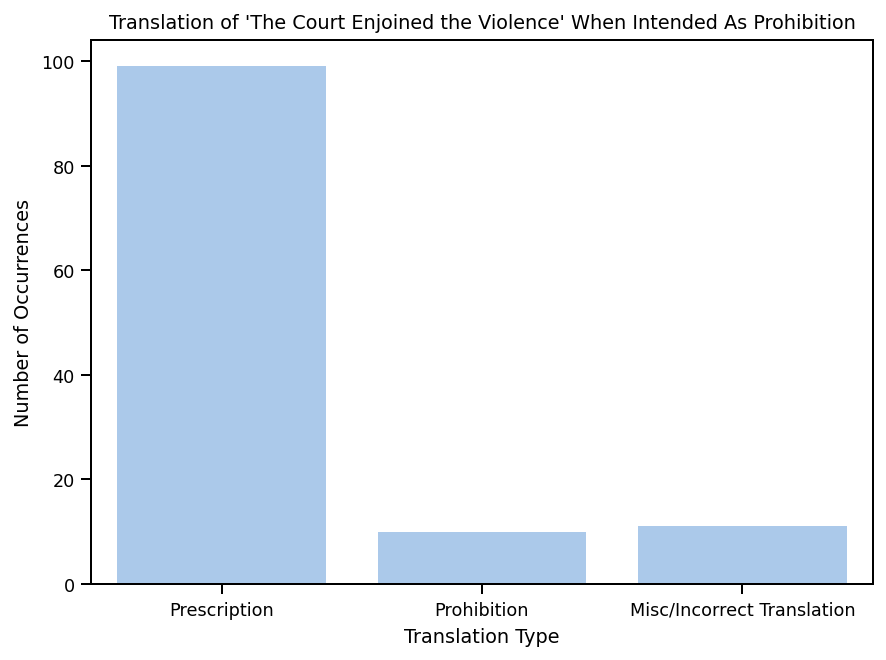

In [65]:
import seaborn as sns
sns.set_context('paper')
sns.set_color_codes('pastel')
d = pd.DataFrame({"Translation Type": ["Prescription", "Prohibition", "Misc/Incorrect Translation"],
                  "Number of Occurrences": [non_nuance, len(nuance_indices), len(misc_indices)]})
f, ax = plt.subplots(figsize = (7,5))

p = sns.barplot(x="Translation Type", y = "Number of Occurrences", data = d, color = 'b' )
# plt.bar(["Prescription", "Prohibition", "Misc/Incorrect Translation"], [non_nuance, len(nuance_indices), len(misc_indices)])
plt.title("Translation of 'The Court Enjoined the Violence' When Intended As Prohibition")
# plt.xlabel("Translation Type")
# plt.ylabel("Number of Occurrences")
p.figure.savefig("longitudinal.jpg")
plt.show()

In [ ]:
# now let's try for "sanction"

sanction_text = "The government sanctioned corruption"
sanction_results = threaded_longitudinal(list_lang.tolist(), sanction_text)

In [ ]:
df_trans_sanction =process_results(sanction_results, list_lang.tolist())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_trans_sanction)

                Language                                    En2Language  \
0              Afrikaans         Die regering het korrupsie goedgekeur    
1               Albanian               Qeveria sanksionoi korrupsionin    
2                Amharic                      መንግሥት ሙስናን ማዕቀብ አስተላልedል    
3                 Arabic                فرضت الحكومة عقوبات على الفساد    
4               Armenian             Կառավարությունը պատժեց կոռուպցիան    
5            Azerbaijani           Hökumət korrupsiyaya sanksiya verdi    
6                 Basque             Gobernuak ustelkeria zigortu zuen    
7             Belarusian                    Урад санкцыянаваў карупцыю    
8                Bengali               সরকার দুর্নীতির অনুমোদন দিয়েছে    
9                Bosnian              Vlada je sankcionirala korupciju    
10             Bulgarian         Правителството санкционира корупцията    
11               Catalan           El govern va sancionar la corrupció    
12               Cebuano 

In [12]:
languages = "afrikaans kannada danish hungarian marathi slovenian albanian divehi icelandic mongolian sorbian amharic dutch interlingua nko spanish arabic english italian norwegian swedish armenian esperanto japanese occitan syriac asturian estonian kannada persian tamil basque finnish khmer piedmontese telugu belarusian french korean polish thai bengali friulian kurdish portuguese tibetan bosnian gaelic lao romanian turkish breton galician latin romansh turkmen bulgarian georgian latvian russian ukrainian catalan german lithuanian sami urdu coptic greek macedonian sanskrit vietnamese croatian hebrew malay serbian welsh czech hindi malayalam slovak".split(" ")

In [36]:
def format_language_tex(lang, string):
  return "\\begin{" + lang + "}" + string + "\\end{" + lang + "}"

In [18]:
print(format_language_tex("arabic", "hi"))

\begin{arabic}hi\end{arabic}


In [37]:
df_trans =process_results(results, list_lang.tolist())
for i, row in df_trans.iterrows():
  l = row[0].lower()
  if l in languages:
    df_trans.iloc[i, 1] = format_language_tex(l, row[1])

In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(df_trans)

                Language                                        En2Language  \
0              Afrikaans  \begin{afrikaans}Die hof beveel die geweld! \e...   
1               Albanian  \begin{albanian}Gjykata urdhëroi dhunën! \end{...   
2                Amharic      \begin{amharic}ፍርድ ቤቱ አመፁን አዘዘ! \end{amharic}   
3                 Arabic    \begin{arabic}أمرت المحكمة بالعنف! \end{arabic}   
4               Armenian  \begin{armenian}Դատարանը պատվիրեց բռնությունը:...   
5            Azerbaijani                         Məhkəmə şiddəti əmr etdi!    
6                 Basque  \begin{basque}Auzitegiak indarkeria agindu zue...   
7             Belarusian  \begin{belarusian}Суд прызначыў гвалт! \end{be...   
8                Bengali  \begin{bengali}আদালত সহিংসতার নির্দেশ দিয়েছে!...   
9                Bosnian  \begin{bosnian}Sud je naredio nasilje! \end{bo...   
10             Bulgarian  \begin{bulgarian}Съдът нареди насилието! \end{...   
11               Catalan  \begin{catalan}El tribunal

In [40]:
df_trans.to_csv("enjoined_with_tex.csv")

In [30]:
f = ""
for i, row in df_trans.iterrows():
  
  l = row[0].lower()
  if l in languages:
    f += l + ","
print(f)

afrikaans,albanian,amharic,arabic,armenian,basque,belarusian,bengali,bosnian,bulgarian,catalan,croatian,czech,danish,dutch,english,esperanto,estonian,finnish,french,galician,georgian,german,greek,hebrew,hindi,hungarian,icelandic,italian,japanese,kannada,khmer,korean,kurdish,lao,latin,latvian,lithuanian,macedonian,malay,malayalam,marathi,mongolian,norwegian,persian,polish,portuguese,romanian,russian,serbian,slovak,slovenian,spanish,swedish,tamil,telugu,thai,turkish,turkmen,ukrainian,urdu,vietnamese,welsh,


In [41]:
df_trans.to_latex("enj_form.tex")